In [152]:
from qutip import basis, sigmax, sigmaz, sigmay, Options 
from qutip.solver.heom import DrudeLorentzBath
from qutip.solver.heom import HEOMSolver
from qutip.solver.heom import DrudeLorentzPadeBath
from qutip.solver.heom import BathExponent
import math
__all__ = ['parallel_map', 'serial_map', 'loky_pmap', 'mpi_pmap']

import multiprocessing
import os
import sys
import time
import threading
import concurrent.futures
import warnings
from qutip.ui.progressbar import progress_bars
from qutip.settings import available_cpu_count
from scipy.fft import fft, ifft 
from scipy.special import shichi
from mpmath import meijerg
import scipy
import matplotlib.pyplot as plt
import qutip
from qutip import ptrace 
import numpy as np 
import time 




# More flexibel solver for custom bath
from qutip.solver.heom import HSolverDL
from qutip.solver.heom import BosonicBath

import qutip.solver.brmesolve as brmesolve 

In [153]:
we=1 # With hbar = 1 this is the upper energy
wg=0# ground state
ve=1 #  ground state frequencie from the exited atomic state in 0.1*we 
w=v=vg=ve# ground state frequencie from the ground atomic state 
Reg=1
μ=1
λ1=-Reg*(ve**2)*μ /(np.sqrt(2*μ *vg**3 ))# dim less coupling constant depending on the shift of the energy minima shifts in space
g=1.0 #couplig cavity to sysem 

tlist = np.linspace(0,60, 500) # 40 times atomic frequencie 4 times vibronic
#### ground parameters
λ2=(vg**2-ve**2)/(4*vg**2) # dim less coupling constant depending on the vibronic freq 
w0=we- wg + λ1**2 *vg**3 /ve**2
w00 = we - wg + (ve - vg )/2
w_cav =(w0+Reg**2*μ*ve**2)
print(λ1)
beta_h=0.01#temp Einheit von  hb*omega durch kb
beta_c=25
A=-λ1/(1+4*λ2)
#A=-λ1*(vg**2/ve**2)

#rs=2*(2*np.pi*1J+np.log(1+4*λ2)**0.25)
rs=1/4*(np.log(ve**2/vg**2))

def nb(w,beta):
    return np.float128(1/(np.exp((w) * beta)-1))
N=14# size of the vibronic hilbi space 
N_Test_Level=2
#tlist=np.linspace[0,1,10]
# operators
b  = qutip.tensor(qutip.qeye(2),qutip.destroy(N),qutip.qeye(N_Test_Level)) #ladder operator of the vibronic modes 
a  = qutip.tensor(qutip.qeye(2),qutip.qeye(N),basis(2,0)*basis(2,1).dag()) #ladder operator of the photonic modes 
ad  = qutip.tensor(qutip.qeye(2),qutip.qeye(N),basis(2,1)*basis(2,0).dag())
P12 = qutip.tensor(basis(2,0)*basis(2,1).dag(),qutip.qeye(N),qutip.qeye(N_Test_Level))
P21 = qutip.tensor(basis(2,1)*basis(2,0).dag(),qutip.qeye(N),qutip.qeye(N_Test_Level))
P11 = qutip.tensor(basis(2,0)*basis(2,0).dag(),qutip.qeye(N),qutip.qeye(N_Test_Level))
P22 = qutip.tensor(basis(2,1)*basis(2,1).dag(),qutip.qeye(N),qutip.qeye(N_Test_Level))
#psi0 = qutip.tensor(basis(2,1),basis(N,0))   #|e,0>
rho0=qutip.tensor(basis(2,1)*basis(2,1).dag(),basis(N,3)*basis(N,3).dag(),basis(N_Test_Level,1)*basis(N_Test_Level,1).dag()) #|e,0><e,0|
H_cav=(w_cav)*ad*a +g*(P21*a+P12*ad)
#System hamiltonian
H= vg*b.dag()*b +w0*P21*P12 + λ1*vg*(b+b.dag())*P21*P12 +H_cav  
D_op=(A*(b.dag()-b)).expm()
#S_op=(1/2*rs*(b*b-b.dag()*b.dag())).expm() #seldmade
U = P12*P21 +(D_op *P21*P12)

#S_op = qutip.tensor(qutip.qeye(2),  S_op)

H_diag=(w0-λ1**2*vg)*(P21*P12) + vg*(b.dag()*b+0.5) + g*(P21*D_op.dag()*a + P12*D_op*ad) + w_cav*ad*a 

P12r=U.dag()*P12*U
P21r=U.dag()*P21*U
c=b+A*P21*P12
#def SS(H):
 #   return (-H*beta_h).expm()/((-H*beta_h).expm().tr())

-0.7071067811865475


In [154]:
"""W=1 # With hbar = 1 this is the upper energy
w=0.1# ground state
x_0=10
g=10
tlist = np.linspace(0,100, 200) # 40 times atomic frequencie 4 times vibronic
#### ground parameters
w_cav=W+w*x_0**2
beta_h=1#temp Einheit von  hb*omega durch kb
beta_c=15


def nb(w,beta):
    return np.float128(1/(np.exp((w) * beta)-1))
N=8# size of the vibronic hilbi space 
N_Test_Level=3
#tlist=np.linspace[0,1,10]
# operators
b  = qutip.tensor(qutip.qeye(2),qutip.destroy(N),qutip.qeye(N_Test_Level)) #ladder operator of the vibronic modes 
a  = qutip.tensor(qutip.qeye(2),qutip.qeye(N),qutip.destroy(N_Test_Level)) #ladder operator of the photonic modes 
ad  = qutip.tensor(qutip.qeye(2),qutip.qeye(N),qutip.destroy(N_Test_Level).dag())
P12 = qutip.tensor(basis(2,0)*basis(2,1).dag(),qutip.qeye(N),qutip.qeye(N_Test_Level))
P21 = qutip.tensor(basis(2,1)*basis(2,0).dag(),qutip.qeye(N),qutip.qeye(N_Test_Level))
P11 = qutip.tensor(basis(2,0)*basis(2,0).dag(),qutip.qeye(N),qutip.qeye(N_Test_Level))
P22 = qutip.tensor(basis(2,1)*basis(2,1).dag(),qutip.qeye(N),qutip.qeye(N_Test_Level))
sigmaz = qutip.tensor(qutip.sigmaz(),qutip.qeye(N),qutip.qeye(N_Test_Level))
print(qutip.sigmap(),basis(2,0)*basis(2,1).dag(),qutip.sigmap()*qutip.sigmam()*qutip.sigmap())
I=qutip.tensor(qutip.qeye(2),qutip.qeye(N),qutip.qeye(N_Test_Level))
#psi0 = qutip.tensor(basis(2,1),basis(N,0))   #|e,0>
rho0=qutip.tensor(basis(2,1)*basis(2,1).dag(),basis(N,0)*basis(N,0).dag(),basis(N_Test_Level,0)*basis(N_Test_Level,0).dag()) #|e,0><e,0|
H_cav=(w_cav)*(ad*a) +g*(P21*a+P12*ad)
#System hamiltonian
H= w*(b.dag()*b) +W*P21*P12 + x_0*w*1/np.sqrt(2)*(b+b.dag())*P21*P12 +H_cav  
#D_op=(A*(b.dag()-b)).expm()
#S_op=(1/2*rs*(b*b-b.dag()*b.dag())).expm() #seldmade
#U = P12*P21 +(D_op *P21*P12)

#S_op = qutip.tensor(qutip.qeye(2),  S_op)

#H_diag=(w0-λ1**2*vg)*(P21*P12) + vg*(b.dag()*b+0.5) + g*(P21*D_op.dag()*a + P12*D_op*ad) + w_cav*ad*a 

#P12r=U.dag()*P12*U
#P21r=U.dag()*P21*U
#c=b+A*P21*P12
#def SS(H):
 #   return (-H*beta_h).expm()/((-H*beta_h).expm().tr())"""

'W=1 # With hbar = 1 this is the upper energy\nw=0.1# ground state\nx_0=10\ng=10\ntlist = np.linspace(0,100, 200) # 40 times atomic frequencie 4 times vibronic\n#### ground parameters\nw_cav=W+w*x_0**2\nbeta_h=1#temp Einheit von  hb*omega durch kb\nbeta_c=15\n\n\ndef nb(w,beta):\n    return np.float128(1/(np.exp((w) * beta)-1))\nN=8# size of the vibronic hilbi space \nN_Test_Level=3\n#tlist=np.linspace[0,1,10]\n# operators\nb  = qutip.tensor(qutip.qeye(2),qutip.destroy(N),qutip.qeye(N_Test_Level)) #ladder operator of the vibronic modes \na  = qutip.tensor(qutip.qeye(2),qutip.qeye(N),qutip.destroy(N_Test_Level)) #ladder operator of the photonic modes \nad  = qutip.tensor(qutip.qeye(2),qutip.qeye(N),qutip.destroy(N_Test_Level).dag())\nP12 = qutip.tensor(basis(2,0)*basis(2,1).dag(),qutip.qeye(N),qutip.qeye(N_Test_Level))\nP21 = qutip.tensor(basis(2,1)*basis(2,0).dag(),qutip.qeye(N),qutip.qeye(N_Test_Level))\nP11 = qutip.tensor(basis(2,0)*basis(2,0).dag(),qutip.qeye(N),qutip.qeye(N_Test_Le

In [155]:
gamma_1=0.1
gamma_2=0.1
def steady(wups):
    
    c_op_list=[]

    c_op_list.append(np.sqrt((nb(w0,beta_h)+1)*gamma_1)*P12)
    c_op_list.append(np.sqrt((nb(w0,beta_h))*gamma_1)*P21)
    c_op_list.append(np.sqrt((nb(w,beta_c)+1)*gamma_2)*b*P12*P21)
    c_op_list.append(np.sqrt((nb(w,beta_c))*gamma_2)*b.dag()*P12*P21)
    c_op_list.append(np.sqrt((nb(w,beta_c)+1)*gamma_2)*b*P21*P12)
    c_op_list.append(np.sqrt((nb(w,beta_c))*gamma_2)*b.dag()*P21*P12)
    
    #H_cav=(wups)*(ad*a) +g*(P21*a+P12*ad)
#System hamiltonian
    #H= w*(b.dag()*b) +W*P21*P12 + x_0*w*1/np.sqrt(2)*(b+b.dag())*P21*P12 +H_cav  
    
    H_cav=(w_cav)*ad*a +g*(P21*a+P12*ad)
#System hamiltonian
    H= vg*b.dag()*b +w0*P21*P12 + λ1*vg*(b+b.dag())*P21*P12 +H_cav  
    rho_ss=qutip.steadystate(H, c_op_list)
    return rho_ss
exited = [None] * 50

for i, _ in enumerate(exited):
    wups = 5 * i / (len(exited) - 1)
    rho_ss = steady(wups)

    # 👉 Übergangserwartungswert oder Populationsmessung
    result = qutip.expect(P21 * P12, rho_ss)

    exited[i] = result

print(exited)
Atomic=rho_ss.ptrace(0)
print(Atomic*qutip.sigmap()*qutip.sigmam())
#print((rho_ss*ad*a).ptrace(2))


[0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.49625007031091795, 0.4962500703

[0.4962500703109153, 0.4962500703109164, 0.4962500703109171, 0.49625007031091595, 0.4962500703109155, 0.4962500703109159, 0.49625007031091667, 0.49625007031091684, 0.49625007031091684, 0.496250070310919, 0.49625007031091706, 0.4962500703109167, 0.4962500703109159, 0.4962500703109153, 0.4962500703109165, 0.49625007031091545, 0.4962500703109169, 0.49625007031091783, 0.49625007031091595, 0.4962500703109158, 0.49625007031091484, 0.49625007031091345, 0.4962500703109159, 0.4962500703109159, 0.49625007031091667, 0.49625007031091434, 0.4962500703109177, 0.4962500703109168, 0.4962500703109158, 0.49625007031091645, 0.49625007031091484, 0.496250070310918, 0.49625007031091617, 0.49625007031091856, 0.49625007031091606, 0.4962500703109161, 0.4962500703109164, 0.49625007031091684, 0.49625007031091745, 0.4962500703109168, 0.4962500703109163, 0.4962500703109171, 0.4962500703109176, 0.49625007031091695, 0.49625007031091756, 0.4962500703109188, 0.4962500703109151, 0.4962500703109162, 0.49625007031091617,

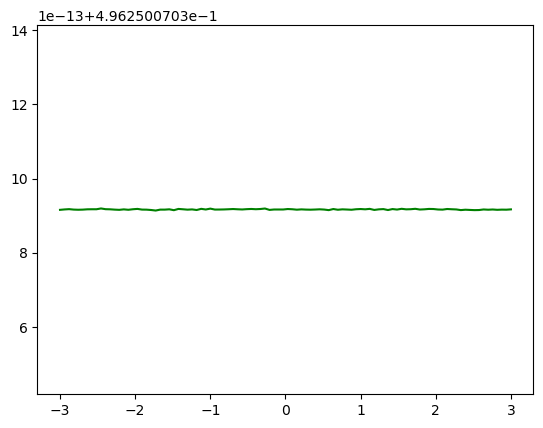

In [156]:
def steady_diag(wups):
    
    c_op_list=[]

    c_op_list.append(np.sqrt((nb(w0,beta_h)+1)*gamma_1)*P12r)
    c_op_list.append(np.sqrt((nb(w0,beta_h))*gamma_1)*P21r)
    c_op_list.append(np.sqrt((nb(w,beta_c)+1)*gamma_2)*b*P12r*P21r)
    c_op_list.append(np.sqrt((nb(w,beta_c))*gamma_2)*b.dag()*P12r*P21r)
    c_op_list.append(np.sqrt((nb(w,beta_c)+1)*gamma_2)*b*P21r*P12r)
    c_op_list.append(np.sqrt((nb(w,beta_c))*gamma_2)*b.dag()*P21r*P12r)
    
    #H_cav=(wups)*(ad*a) +g*(P21*a+P12*ad)
#System hamiltonian
    #H= w*(b.dag()*b) +W*P21*P12 + x_0*w*1/np.sqrt(2)*(b+b.dag())*P21*P12 +H_cav  
    
    
    H_diag=(w0-λ1**2*vg)*(P21*P12) + vg*(b.dag()*b+0.5) + g*(P21*D_op.dag()*a + P12*D_op*ad) + wups*ad*a  
    rho_ss=qutip.steadystate(H_diag, c_op_list)
    return rho_ss
exited = [None] * 100
wups_list=[]

for i, _ in enumerate(exited):
    wups = 6 *i / (len(exited) - 1) -3
    rho_ss = steady_diag(wups)
    wups_list.append(wups)
    # 👉 Übergangserwartungswert oder Populationsmessung
    result = qutip.expect(P21 * P12, rho_ss)
    
    exited[i] = result
fig, ax = plt.subplots()
ax.plot(wups_list, exited,color="green")
print(exited)
Atomic=rho_ss.ptrace(0)
print(Atomic*qutip.sigmap()*qutip.sigmam())

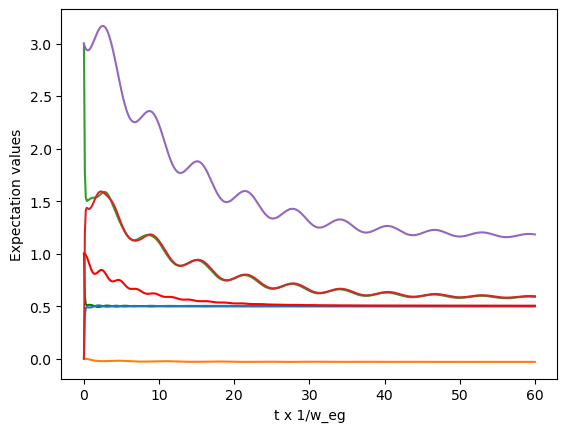

In [157]:
c_op_list=[]

c_op_list.append(np.sqrt((nb(w0,beta_h)+1)*gamma_1)*P12)
c_op_list.append(np.sqrt((nb(w0,beta_h))*gamma_1)*P21)
c_op_list.append(np.sqrt((nb(w,beta_c)+1)*gamma_2)*b*P12*P21)
c_op_list.append(np.sqrt((nb(w,beta_c))*gamma_2)*b.dag()*P12*P21)
c_op_list.append(np.sqrt((nb(w,beta_c)+1)*gamma_2)*b*P21*P12)
c_op_list.append(np.sqrt((nb(w,beta_c))*gamma_2)*b.dag()*P21*P12)
Resul_Lindblad=qutip.mesolve(H, rho0, tlist, [c_op_list], [P21*P12, P12*P21,P12,b.dag()*b*P21*P12,b.dag()*b*P12*P21,b.dag()*b*P21*P12+b.dag()*b*P12*P21,ad*a])
fig, ax = plt.subplots()
ax.plot(tlist, Resul_Lindblad.expect[0],color="green")
ax.plot(tlist, Resul_Lindblad.expect[1])
ax.plot(tlist, Resul_Lindblad.expect[2])
ax.plot(tlist, Resul_Lindblad.expect[3])
ax.plot(tlist, Resul_Lindblad.expect[4])
ax.plot(tlist, Resul_Lindblad.expect[5])
ax.plot(tlist, Resul_Lindblad.expect[6],color="red")
#P1 = np.exp(-beta_h * w0 / 2) / (np.exp(-beta_h * w0 / 2) + np.exp(beta_h * w0 / 2))
#ax.plot(tlist,np.exp(-gamma_1 *(2*nb(w00,beta_h)+1)*tlist)+P1*(1-np.exp(-gamma_1 *(2*nb(w00,beta_h))*tlist)),linestyle='dashdot') 
ax.set_xlabel('t x 1/w_eg')
ax.set_ylabel('Expectation values')
#ax.legend(("Pe", "Pg","P12","N * P22 ","N * P11","N*P22+N*P11"))

#ax.axhline(y=1/(np.exp(beta*vg)-1), xmin=0, xmax=40, color='b', linestyle='--')
#ax.axhline(y=0.5, xmin=0, xmax=40, color='b', linestyle='--')
plt.show()

In [158]:
gamma_1_diag=0.1
gamma_2_diag=0.1
c_op_list_diag=[]

c_op_list_diag.append(np.sqrt((nb(w0,beta_h)+1)*gamma_1_diag)*P12r)
c_op_list_diag.append(np.sqrt((nb(w0,beta_h))*gamma_1_diag)*P21r)
c_op_list_diag.append(np.sqrt((nb(w,beta_c)+1)*gamma_2_diag)*c*P12r*P21r)
c_op_list_diag.append(np.sqrt((nb(w,beta_c))*gamma_2_diag)*c.dag()*P12r*P21r)
c_op_list_diag.append(np.sqrt((nb(w,beta_c)+1)*gamma_2_diag)*c*P21r*P12r)
c_op_list_diag.append(np.sqrt((nb(w,beta_c))*gamma_2_diag)*c.dag()*P21r*P12r)


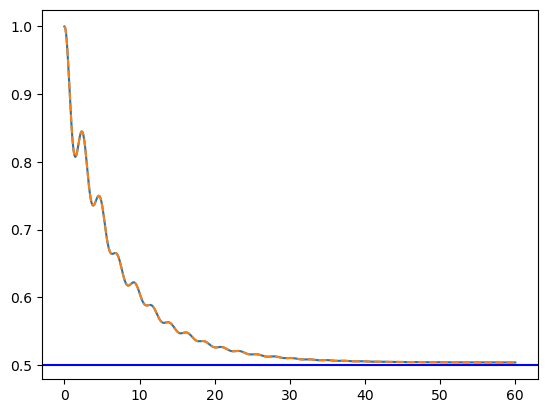

In [159]:
Resul_Lindblad_diag=qutip.mesolve(H_diag, U.dag()*rho0*U, tlist, [c_op_list_diag], [P21r*P12r, P12r*P21r,P12r,c.dag()*c*P21r*P12r,U.dag()*b.dag()*b*U*P12r*P21r,U.dag()*ad*a*U])
fig, ax = plt.subplots()
#ax.plot(tlist, Resul_Lindblad_diag.expect[0])
#ax.plot(tlist, Resul_Lindblad_diag.expect[2])
#ax.plot(tlist, Resul_Lindblad_diag.expect[3])
#ax.plot(tlist, Resul_Lindblad_diag.expect[4])
ax.plot(tlist, Resul_Lindblad_diag.expect[5])
"""ax.plot(tlist, Resul_Lindblad.expect[0],linestyle="--")
ax.plot(tlist, Resul_Lindblad.expect[2],linestyle="--")
ax.plot(tlist, Resul_Lindblad.expect[3],linestyle="--")
ax.plot(tlist, Resul_Lindblad.expect[4],linestyle="--")"""
ax.plot(tlist, Resul_Lindblad.expect[6],linestyle="--")
ax.axhline(y=0.5, xmin=0, xmax=40, color='b', linestyle='-')